# Objective
* 20190102: 
    * Predict stock price in next day using long short term memory(LSTM)
    * Given prices for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190120 - Diff from SotckPricePrediction_v4_lstm.ipynb: 
    * Instead of MinMaxScaler, here we use StandardScaler
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [0]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = "ouput.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
set_random_seed(model_seed)

Using TensorFlow backend.


# Common functions

In [0]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Load data

In [0]:
df = pd.read_csv('output.csv')

# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()



,date,close,close_12_ema,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_-1_s,close_-1_d,rs_12,rsi_12,rsi,price-change,change,month
0,2004-08-20,54.3227,52.489413,52.399671,0.089741,0.049856,0.079770,52.322750,2.828356,52.322750,57.979463,46.666037,50.3228,3.9999,inf,100.000000,100.000000,3.9999,1.0,8
1,2004-08-23,54.8694,53.418322,53.287021,0.131301,0.083235,0.096132,53.171633,2.482259,53.171633,58.136151,48.207116,54.3227,0.5467,inf,100.000000,100.000000,0.5467,1.0,8
2,2004-08-24,52.5974,53.159189,53.094233,0.064956,0.077043,-0.024174,53.028075,2.046992,53.028075,57.122058,48.934092,54.8694,-2.2720,1.699898,62.961567,62.961567,-2.2720,0.0,8
3,2004-08-25,53.1641,53.160523,53.110435,0.050088,0.069025,-0.037873,53.055280,1.773790,53.055280,56.602861,49.507699,52.5974,0.5667,1.972001,66.352639,66.352639,0.5667,1.0,8
4,2004-08-26,54.1221,53.394237,53.313064,0.081173,0.072318,0.017711,53.233083,1.645220,53.233083,56.523524,49.942643,53.1641,0.9580,2.473806,71.213126,71.213126,0.9580,1.0,8


Text(0, 0.5, 'USD')

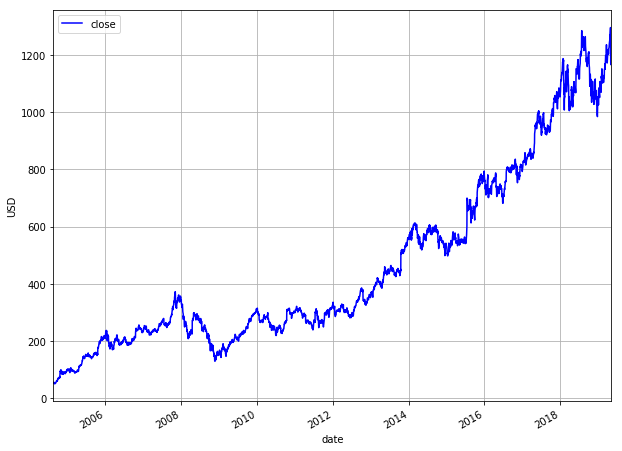

In [0]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test sets

We use lags up to N number of days to use as features.

In [0]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))
print(df.columns)
# Split into train, cv, and test
train = df[:num_train][['date', 'close','macd','boll','rsi','change']]
cv = df[num_train:num_train+num_cv][['date', 'close','macd','boll','rsi','change']]
train_cv = df[:num_train+num_cv][['date', 'close','macd','boll','rsi','change']]
test = df[num_train+num_cv:][['date', 'close','macd','boll','rsi','change']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))
print(train)

num_train = 2224
num_cv = 740
num_test = 740
Index(['date', 'close', 'close_12_ema', 'close_26_ema', 'macd', 'macds',
       'macdh', 'close_20_sma', 'close_20_mstd', 'boll', 'boll_ub', 'boll_lb',
       'close_-1_s', 'close_-1_d', 'rs_12', 'rsi_12', 'rsi', 'price-change',
       'change', 'month'],
      dtype='object')
train.shape = (2224, 6)
cv.shape = (740, 6)
train_cv.shape = (2964, 6)
test.shape = (740, 6)
           date     close       macd        boll         rsi  change
0    2004-08-20   54.3227   0.089741   52.322750  100.000000     1.0
1    2004-08-23   54.8694   0.131301   53.171633  100.000000     1.0
2    2004-08-24   52.5974   0.064956   53.028075   62.961567     0.0
3    2004-08-25   53.1641   0.050088   53.055280   66.352639     1.0
4    2004-08-26   54.1221   0.081173   53.233083   71.213126     1.0
5    2004-08-27   53.2393   0.059718   53.233971   62.183145     0.0
6    2004-08-30   51.1629  -0.054382   52.975088   46.917930     0.0
7    2004-08-31   51.3435  -0.12

In [0]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [244.88507918]
scaler.var_ = [6272.51602608]
x_train_scaled.shape = (2215, 9, 1)
y_train_scaled.shape = (2215, 1)


In [0]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (740, 9, 1)
y_cv.shape = (740, 1)
len(mu_cv_list) = 740
len(std_cv_list) = 740


In [0]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['close']).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [331.68688792]
scaler_final.var_ = [29612.50132106]


# Create and fit the LSTM network

In [0]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 59s - loss: 0.0264


In [0]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


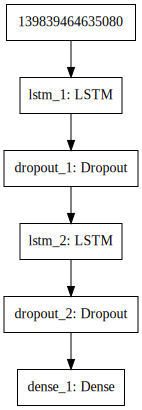

In [0]:
# Plot model and save to file
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Predict on dev set

In [0]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (740, 1)
RMSE = 13.752
MAPE = 1.574%


cell 13


Text(0, 0.5, 'USD')

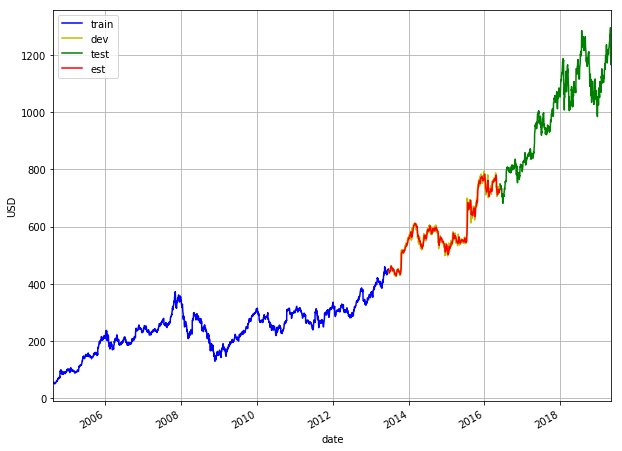

In [0]:
# Plot adjusted close over time
print('cell 13')
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Tuning N (no. of days to use as features)

In [0]:
# print('cell 14')
# param_label = 'N'
# param_list = range(3, 60)

# error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
# tic = time.time()
# for param in tqdm_notebook(param_list):
    
#     # Split train into x and y
#     x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

#     # Split cv into x and y
#     x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), param, num_train)
    
#     # Train, predict and eval model
#     rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
#                                           y_train_scaled, \
#                                           x_cv_scaled, \
#                                           y_cv, \
#                                           mu_cv_list, \
#                                           std_cv_list, \
#                                           lstm_units=lstm_units, \
#                                           dropout_prob=dropout_prob, \
#                                           optimizer=optimizer, \
#                                           epochs=epochs, \
#                                           batch_size=batch_size)
    
#     # Collect results
#     error_rate[param_label].append(param)
#     error_rate['rmse'].append(rmse)
#     error_rate['mape_pct'].append(mape)
    
# error_rate = pd.DataFrame(error_rate)
# toc = time.time()
# print("Minutes taken = " + str((toc-tic)/60.0))
# error_rate   

In [0]:
print('cell 15')
# Plot RMSE 
#rcParams['figure.figsize'] = 10, 8 # width 10, height 8

#ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
#ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
#ax.set_xlabel("N")
#ax.set_ylabel("RMSE/MAPE(%)")

cell 15


In [0]:
# Get optimum value for param
#temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
#N_opt = temp['N'].values[0]
#print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
#print("optimum " + param_label + " = " + str(N_opt))

NameError: ignored

# Tuning model - epochs and batch_size

In [0]:
# param_label = 'epochs'
# param_list = [1, 10, 20, 30, 40, 50]

# param2_label = 'batch_size'
# param2_list = [8, 16, 32, 64, 128]

# # Split train into x and y
# x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# # Split cv into x and y
# x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N_opt, num_train)

# error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
# tic = time.time()
# for param in tqdm_notebook(param_list):
    
#     for param2 in tqdm_notebook(param2_list):
    
#         # Train, predict and eval model
#         rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
#                                               y_train_scaled, \
#                                               x_cv_scaled, \
#                                               y_cv, \
#                                               mu_cv_list, \
#                                               std_cv_list, \
#                                               lstm_units=lstm_units, \
#                                               dropout_prob=dropout_prob, \
#                                               optimizer=optimizer, \
#                                               epochs=param, \
#                                               batch_size=param2)
    
#         # Collect results
#         error_rate[param_label].append(param)
#         error_rate[param2_label].append(param2)
#         error_rate['rmse'].append(rmse)
#         error_rate['mape_pct'].append(mape)
    
# error_rate = pd.DataFrame(error_rate)
# toc = time.time()
# print("Minutes taken = " + str((toc-tic)/60.0))
# error_rate   

In [0]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [0]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

# Tuning model - LSTM units and dropout prob

In [0]:
# param_label = 'lstm_units'
# param_list = [10, 50, 64, 128]

# param2_label = 'dropout_prob'
# param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
# tic = time.time()
# for param in tqdm_notebook(param_list):
    
#     for param2 in tqdm_notebook(param2_list):
    
#         # Train, predict and eval model
#         rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
#                                               y_train_scaled, \
#                                               x_cv_scaled, \
#                                               y_cv, \
#                                               mu_cv_list, \
#                                               std_cv_list, \
#                                               lstm_units=param, \
#                                               dropout_prob=param2, \
#                                               optimizer=optimizer, \
#                                               epochs=epochs_opt, \
#                                               batch_size=batch_size_opt)
    
#         # Collect results
#         error_rate[param_label].append(param)
#         error_rate[param2_label].append(param2)
#         error_rate['rmse'].append(rmse)
#         error_rate['mape_pct'].append(mape)
    
# error_rate = pd.DataFrame(error_rate)
# toc = time.time()
# print("Minutes taken = " + str((toc-tic)/60.0))
# error_rate   

In [0]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [0]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

# Tuning model - optimizer

In [0]:
# param_label = 'optimizer'
# param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

# error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
# tic = time.time()
# for param in tqdm_notebook(param_list):
   
#     # Train, predict and eval model
#     rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
#                                           y_train_scaled, \
#                                           x_cv_scaled, \
#                                           y_cv, \
#                                           mu_cv_list, \
#                                           std_cv_list, \
#                                           lstm_units=lstm_units_opt, \
#                                           dropout_prob=dropout_prob_opt, \
#                                           optimizer=param, \
#                                           epochs=epochs_opt, \
#                                           batch_size=batch_size_opt)
    
#     # Collect results
#     error_rate[param_label].append(param)
#     error_rate['rmse'].append(rmse)
#     error_rate['mape_pct'].append(mape)
    
# error_rate = pd.DataFrame(error_rate)
# toc = time.time()
# print("Minutes taken = " + str((toc-tic)/60.0))
# error_rate   

In [0]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [0]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

# Tuned params

In [0]:
# d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
#      'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
#      'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
# tuned_params = pd.DataFrame(d)
# tuned_params

# Final model

In [0]:
N_opt = 30
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=50, \
                                        dropout_prob=0.6, \
                                        optimizer='adamax', \
                                        epochs=1, \
                                        batch_size= 16)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 29.477
MAPE on test set = 2.207%


Text(0, 0.5, 'USD')

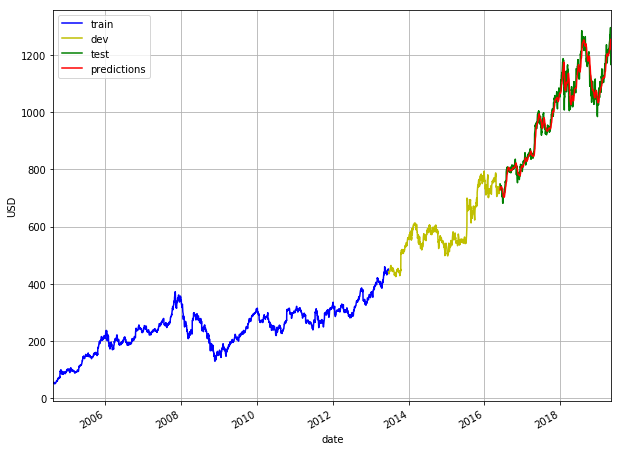

In [0]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

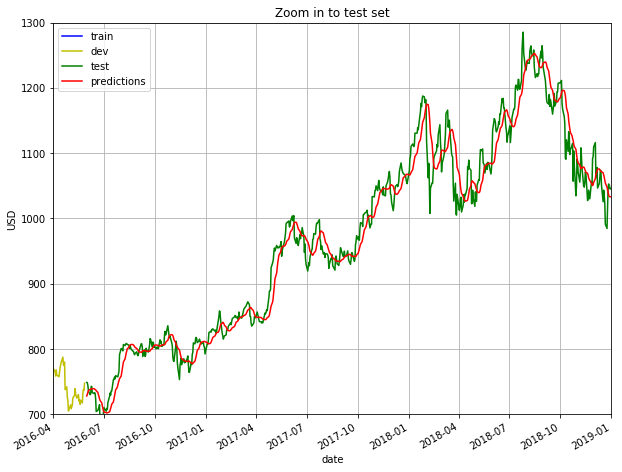

In [0]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2016, 4, 1), date(2019, 1, 1)])
ax.set_ylim([700, 1300])
ax.set_title("Zoom in to test set")

In [0]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2019, 1, 1)])
ax.set_ylim([700, 1300])

In [0]:
# Save as csv
test_lstm = est_df
test_lstm.to_csv("./out/test_lstm.csv")

# Findings
* On the test set, the RMSE is 1.164 and MAPE is 0.583% using N_opt=3